In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from astropy import units as u
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
import poppy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 21/11/2021 16:08:45


In [2]:
%%time
# initialize the data
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 0.019*u.m, #19*u.mm,
             'label': '19mm',
             'fm_num': 1,
             'surf_units': u.micron,
             'ring_width': 3,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m} #1/u.mm}

fits_folder = 'zygo_data/flat_mirrors/fixed_fits/'
fm_loc = fits_folder+'flat_{0}_n{1}_{2}CA_glue'.format(opt_parms['label'], opt_parms['fm_num'], opt_parms['ca'])

fm = psd.surfPSD(surf_name='fm_{0}'.format(opt_parms['label']))
fm.open_surf(fileloc=fm_loc+'_surf.fits', surf_units=opt_parms['surf_units'])
fm.open_mask(fileloc=fm_loc+'_mask.fits')
fm.calc_psd(oversamp=opt_parms['ovs'], kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'])
fm.calc_psd_radial(ring_width=opt_parms['ring_width'], kmin=fm.k_min)
#fm.write_psd_file(filename=fits_folder+'flat_{0}_ca{1}_gluedata_PSD.fits'.format(opt_parms['label'], opt_parms['ca']),
#                  psd_data=fm.psd_cal,
#                  single_precision=False)

# add in values to opt_parms to make code easier to use
opt_parms['dk'] = fm.delta_k
opt_parms['diam_ca'] = fm.diam_ca
opt_parms['diam_pix'] = fm.npix_diam
opt_parms['wavelen'] = fm.wavelen

CPU times: user 2min 33s, sys: 54 s, total: 3min 27s
Wall time: 3min 25s


In [13]:
fm.rms_tot

<Quantity 14.45154862 nm>

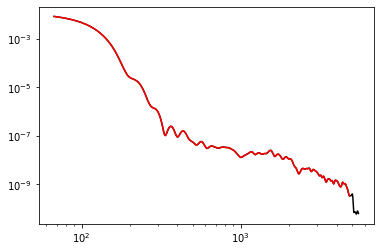

In [3]:
# Throw away some of the high-k ending data for better fitting
# The last data doesn't seem critical anyways
plt.loglog(fm.k_radial.value, fm.psd_radial_cal.value, label='full', color='k')

# cropping
fin = len(fm.k_radial)
offset = 250 # if you change this number, you must re-run above code.
fm.k_radial = fm.k_radial[0:fin-offset]
fm.psd_radial_cal = fm.psd_radial_cal[0:fin-offset]
plt.loglog(fm.k_radial.value, fm.psd_radial_cal.value, label='cropped', color='r')

Text(0, 0.5, 'Power Spectrum [$nm^{2}$$m^{2}$]')

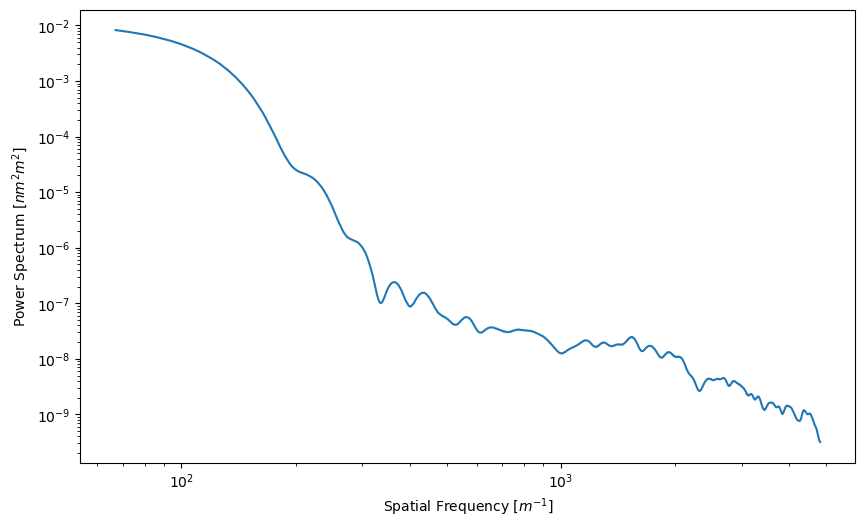

In [4]:
plt.figure(figsize=[10,6],dpi=100, facecolor='white')
plt.loglog(fm.k_radial.value, fm.psd_radial_cal.value)#, label='Average PSD')#, RMS={0:.3f}'.format(avg_rms))
plt.xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
plt.ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))
#plt.title('MagAO-X PSD: flat mirrors {0} glue, 80% CA, dust mask averaged steps'.format(flat_label))
#plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:
# save the cropped data
psd_dict = {'k_radial': fm.k_radial,
            'psd_radial': fm.psd_radial_cal,
            'rms_tot': fm.rms_tot,
            'var': fm.var,
            'diam_ca': fm.diam_ca,
            'npix_diam': fm.npix_diam,
            'oversamp': fm.oversamp,
            'delta_k': fm.delta_k,
            'k_min': fm.k_min,
            'k_max': fm.k_max,
            'ring_width': opt_parms['ring_width']}

psd.psd_radial_to_fits(psd_dict=psd_dict, opt_name=opt_parms['label'],
                       fits_filename='radial/psd_fm{0}_glue.fits'.format(opt_parms['label']))

In [5]:
%%time
ist = [0, 50, 98]#, 55]
iend = [ist[1],
        ist[2],
        len(fm.k_radial)-1]
rms_sr = [0.00005*u.nm, 
          0.00005*u.nm,
          0.08*u.nm]
psd_weight = [1.0, 
              1.0,
              1.0]
k_limit = [np.amin(fm.k_radial)/10, np.amax(fm.k_radial)*10]
surf_unit = (fm.psd_radial_cal.unit * (fm.k_radial.unit**2))**(0.5)
mdl_set = []
x0 = [[1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5]]
for j in range(0, len(ist)):
    mdl = psd.model_single(region_num=j)
    mdl.load_data(ind_range=[ist[j],iend[j]], psd_obj=fm)
    mdl.calc_psd_parm(rms_sr=rms_sr[j], x0=x0[j])#, ratio_mode=False)
    mdl.calc_model_total(psd_weight=psd_weight[j], k_spacing=opt_parms['dk']*0.2, k_limit=k_limit)
    mdl_set.append(mdl)

# model sum with a total refit
ms_refit = psd.model_combine(mdl_set=mdl_set, avg_psd=fm)
ms_refit.calc_refit()
ms_refit.calc_error()
ms_refit.calc_psd_rms()

/home/jhen/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 27 s, sys: 864 ms, total: 27.8 s
Wall time: 18.5 s


In [12]:
ms_refit.psd_rms_sum

<Quantity 14.46547964 nm>

In [10]:
def psd_plot(mdl_set, model_sum, avg_psd, opt_parms, psd_lim):
    k_radial = avg_psd.k_radial.value
    psd_radial = avg_psd.psd_radial_cal.value
    k_range_mdl = mdl_set[0].k_range.value

    color_list=['r', 'b', 'y', 'g', 'c']
    anno_opts = dict(xy=(0.11, .9), xycoords='axes fraction',
                     va='center', ha='center')

    matplotlib.rcParams["font.size"]=20
    plt.figure(figsize=[16,9],dpi=100, facecolor='white')
    gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])

    # top PSD: the modeled portion
    ax0 = plt.subplot(gs[0])  

    # measured data
    ax0.loglog(k_radial, psd_radial, 'k', linewidth=4, 
               label='PSD (measured)')

    # regional pieces
    for j in range(0, len(mdl_set)):
        psd_value = psd.model_full(k=mdl_set[0].k_range, psd_parm=model_sum.psd_parm[j]) * model_sum.psd_weight[j]
        plt_label = '{0}: {1}={2:.2f}\n'.format(r'$r_{0}$'.format(mdl_set[j].region_num), 
                                              r'$a_{0}$'.format(j), 
                                              model_sum.psd_weight[j])
        plt_label = plt_label+ '{1}={2:.3f} {3}={4:.3e}\n'.format(r'$r_{0}$'.format(mdl_set[j].region_num),
                                                             r'$\alpha$', model_sum.psd_parm[j][0], 
                                                             r'$\beta$', model_sum.psd_parm[j][1].value)
        plt_label = plt_label + '{0}={1:.1e}, {2}={3:.2e}\n'.format(r'$L_{0}$',model_sum.psd_parm[j][2], 
                                                                                   r'$l_{0}$', model_sum.psd_parm[j][3])
        plt_label = plt_label + '{0}={1:.1e}'.format(r'$\sigma_{sr}$', mdl_set[j].rms_sr)
        #plt_label = plt_label + '{0}={1:.2f}'.format(r'$a_{0}$'.format(j), model_sum.psd_weight[j])
        ax0.loglog(mdl_set[j].k_range.value, psd_value.value, color_list[j]+':', linewidth=2,
                   label=plt_label)
        # draw in the color box
        ax0.axvspan(k_radial[mdl_set[j].i_start], k_radial[mdl_set[j].i_end], facecolor=color_list[j], alpha=0.1)

    #mdl_sum_text = 'model sum {0}\nRMS={1:.5f}'.format(r'$\Sigma a_{n}r_{n}$', model_sum.psd_rms_sum)
    mdl_sum_text = 'PSD (model)'
    ax0.loglog(k_range_mdl, model_sum.psd_radial_sum.value, linewidth=3, label=mdl_sum_text)


    ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
    ax0.set_ylim(top=psd_lim[0], bottom=psd_lim[1])
    ax0.set_ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))
    ax0.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size':14})

    err_rms = np.sqrt(np.mean(np.square(model_sum.error)))
    ax1 = plt.subplot(gs[1])
    ax1.semilogx(k_radial, model_sum.error, linewidth=2)
    ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k')
    ax1.set_ylim(top=0.4, bottom=-0.4)
    ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
    ax1.set_ylabel('Error ratio')# [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))
    ax1.set_xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
    ax1.annotate('Error RMS: {0:.4}'.format(err_rms), **anno_opts, fontsize=15)

    plt.tight_layout()

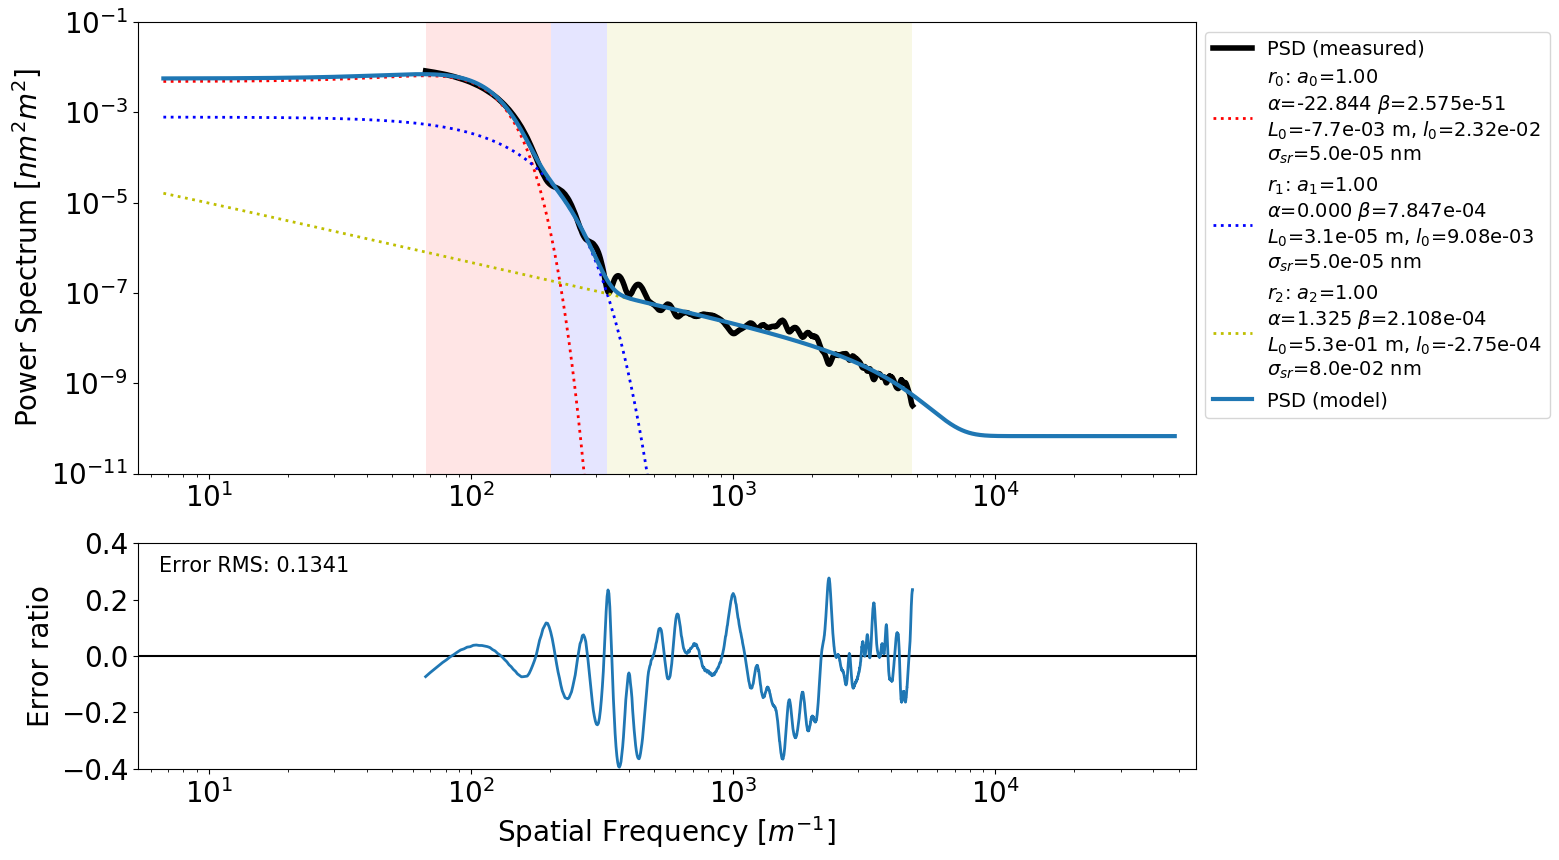

In [11]:
psd_plot(mdl_set, ms_refit, fm, opt_parms, psd_lim=[1e-1, 1e-11])

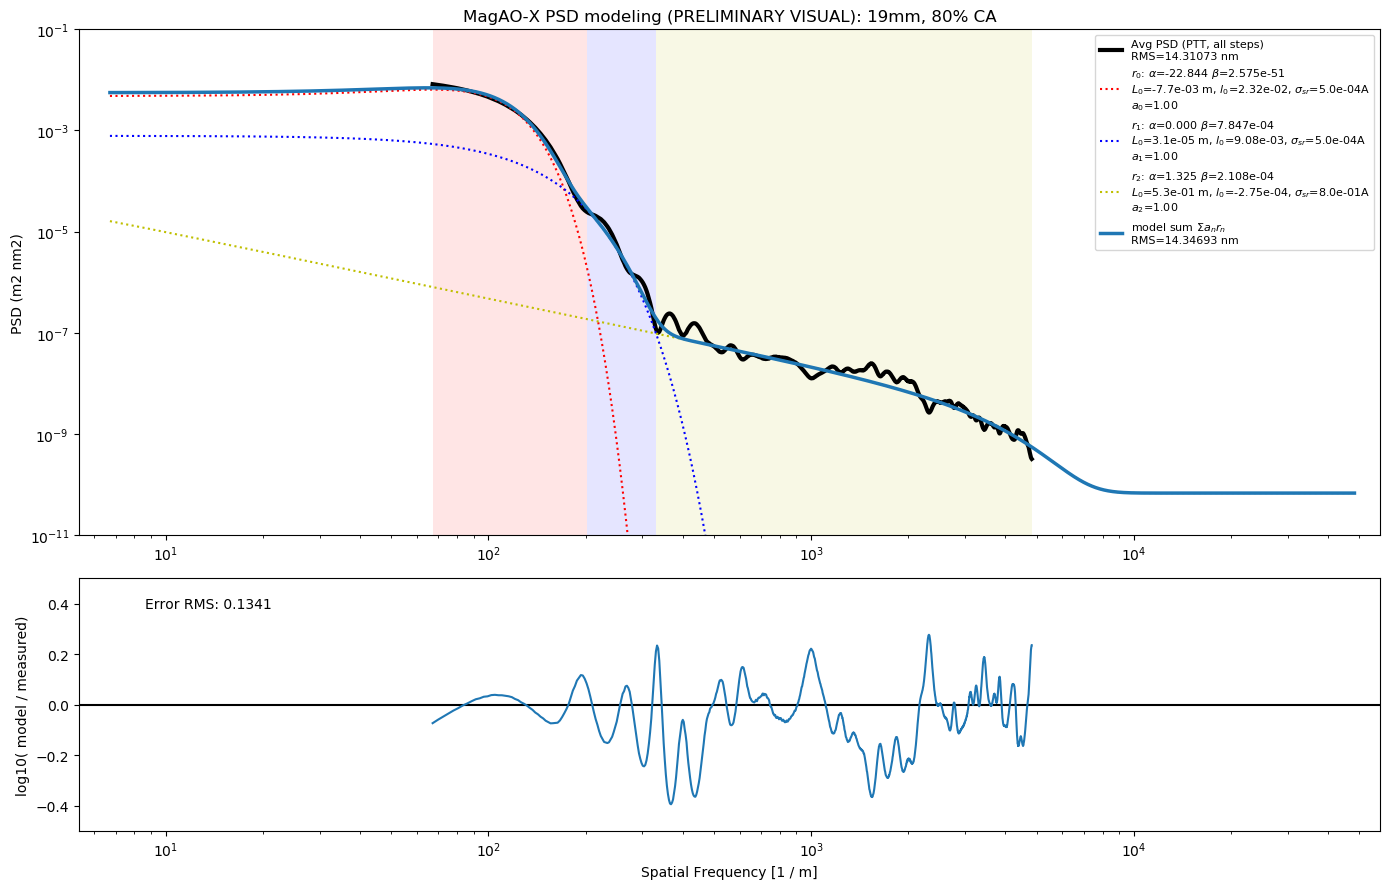

In [8]:
psd.plot_model2(mdl_set, ms_refit, fm, opt_parms, psd_range=[1e-1, 1e-11])

In [9]:
# set the spatial frequency regions based on the index values
k_start = []
k_end = []
for k in range(0, len(ist)):
    k_start.append(fm.k_radial[ist[k]].value)
    k_end.append(fm.k_radial[iend[k]].value)
k_start*=fm.k_radial[0].unit
k_end*=fm.k_radial[0].unit

# set the names
opt_name = 'fm'+opt_parms['label']+'_glue'
parm_name = 'psd_{0}'.format(opt_name)
weight_name = parm_name + '_weight'
rms_name = parm_name + '_rms'

# set the PSD dictionary values
psd_dict = {parm_name: ms_refit.psd_parm,
            weight_name: psd_weight,
            rms_name: fm.rms_tot,
            'k_start': k_start,
            'k_end': k_end,
            'rms_mod': ms_refit.psd_rms_sum,
            'rms_err': ms_refit.error_rms,
            'k_range': ms_refit.k_radial_data,
            'err_data': ms_refit.error,
            'mdl_data': ms_refit.psd_radial_sum_data,
            'psd_data': ms_refit.psd_radial_data}

# save the dictionary as a .FITS table file
fits_filename = 'model_parameters/psd_parms_{0}.fits'.format(opt_name)
psd.psd_model_to_fits(psd_dict=psd_dict, opt_name=opt_name, 
                     fits_filename=fits_filename,
                     surf_unit=u.nm, lat_unit=u.m)

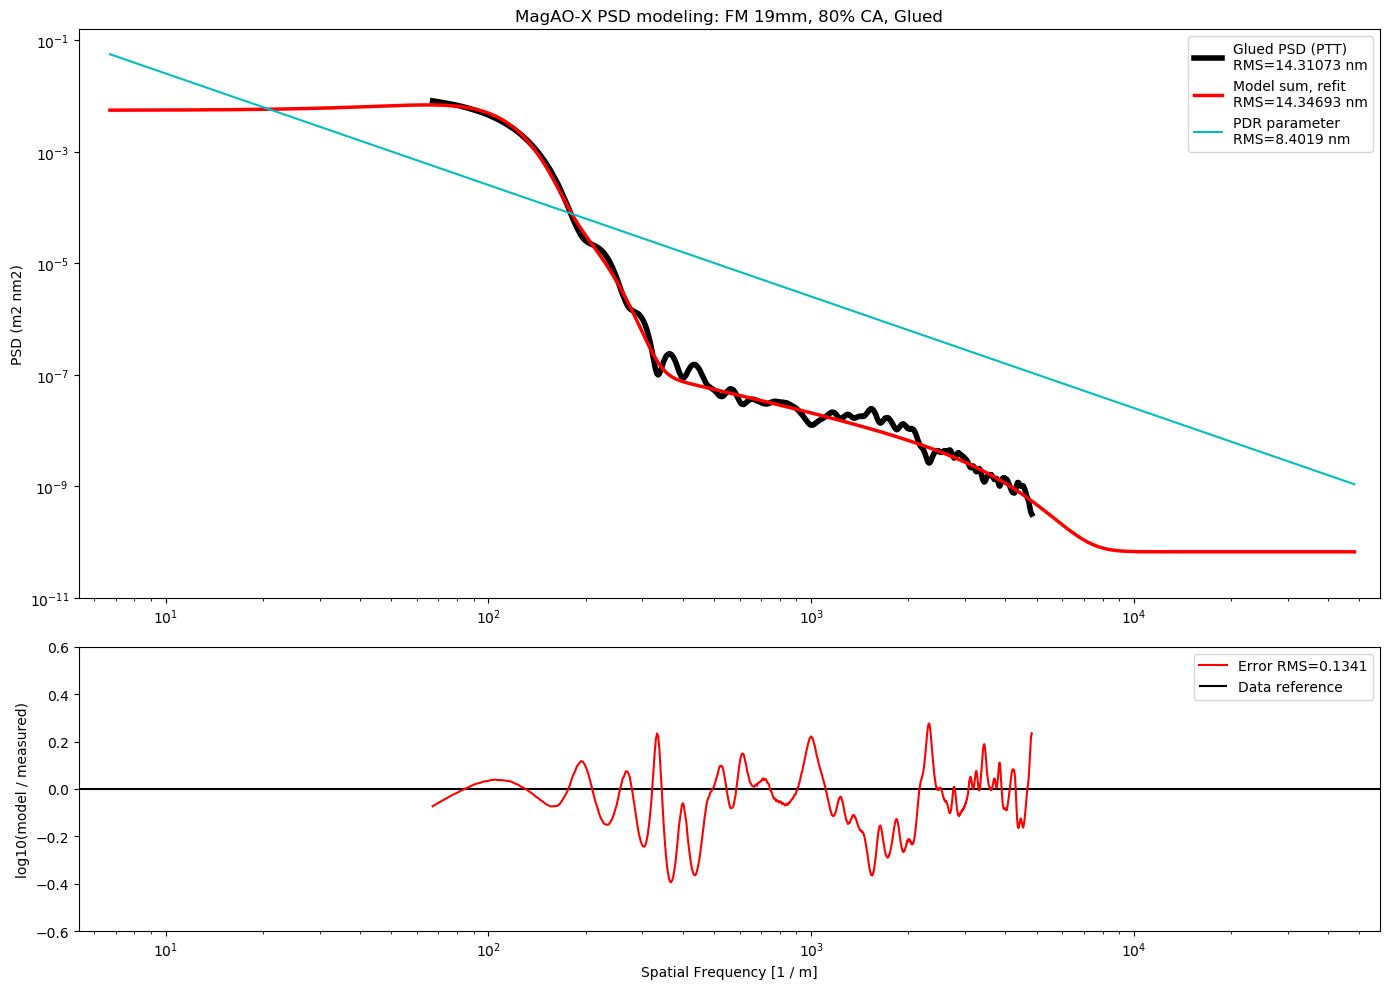

In [10]:
ap = 2.0
bp = 2.55 * (u.nm**2)
parm_pdr = [ap, bp, 0.0*u.m, 0.0, 0*(u.nm*u.m)**2]
psd_pdr = psd.model_full(k=mdl_set[0].k_range, psd_parm=parm_pdr)
pdr_weight = [1.0]

pdr_rms = psd.calc_model_rms(psd_parm=[parm_pdr], psd_weight=pdr_weight, 
                             side=ms_refit.side, delta_k=ms_refit.delta_k,
                             k_tgt_lim=[ms_refit.k_min, ms_refit.k_max])

k_radial = fm.k_radial.value
psd_radial = fm.psd_radial_cal.value
k_range_mdl = mdl_set[0].k_range.value

plt.figure(figsize=[14,10],dpi=100)
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])
ax0 = plt.subplot(gs[0])  
ax0.loglog(k_radial, psd_radial, 'k', linewidth=4, 
           label='Glued PSD (PTT)\nRMS={0:.5f}'.format(fm.rms_tot))
ax0.loglog(k_range_mdl, ms_refit.psd_radial_sum.value, 'r', linewidth=2.5, 
           label='Model sum, refit\nRMS={0:.5f}'.format(ms_refit.psd_rms_sum))
ax0.loglog(k_range_mdl, psd_pdr.value, 'c', linewidth=1.5, label='PDR parameter\nRMS={0:.4f}'.format(pdr_rms))
ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax0.set_ylim(bottom=1e-11)
ax0.set_ylabel('PSD ({0})'.format(ms_refit.psd_radial_sum.unit))
ax0.legend(prop={'size':10})#,loc='center left', bbox_to_anchor=(1, 0.5))
ax0.set_title('MagAO-X PSD modeling: FM 19mm, {0}% CA, Glued'.format(opt_parms['ca']))

ax1 = plt.subplot(gs[1])
ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k', label='Data reference')
ax1.semilogx(k_radial, ms_refit.error, 'r', label='Error RMS={0:.4f}'.format(ms_refit.error_rms))
ax1.legend(prop={'size':10})
ax1.set_ylim(top=0.6, bottom=-0.6)
ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax1.set_ylabel('log10(model / measured)')
ax1.set_xlabel('Spatial Frequency [{0}]'.format(ms_refit.k_radial_data.unit))

plt.tight_layout()